<a href="https://colab.research.google.com/github/CPernet/OpenNeuro_MetaPrivAssessment/blob/main/TheMidnightScanClub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Link to the repo and import local data and library

In [1]:
!git clone https://github.com/CPernet/OpenNeuro_MetaPrivAssessment.git

import sys
sys.path.append("..")
import os
os.chdir('OpenNeuro_MetaPrivAssessment') # Change directory to the cloned repository

Cloning into 'OpenNeuro_MetaPrivAssessment'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 189 (delta 70), reused 97 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (189/189), 4.26 MiB | 13.95 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [2]:
%%bash
set -e
sudo apt-get update -qq
sudo DEBIAN_FRONTEND=noninteractive \
     apt-get install -qq -y --no-install-recommends r-base r-base-dev

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import spearmanr, kendalltau, linregress
import warnings
warnings.filterwarnings('ignore')
!pip install piflib
import logging
logging.getLogger('rpy2.rinterface_lib.callbacks').setLevel(logging.ERROR)
!pip install -q rpy2
import metaprivBIDS_stat as ST
from metaprivBIDS_stat import plot_calc
from metaprivBIDS_stat import rst_outlier_case2

## Import result files from metaprivBIDS App analysis

MID is the raw dataset "The Midnight Scan Club (MSC) dataset".

In [5]:
MID = 'https://s3.amazonaws.com/openneuro.org/ds000224/participants.tsv?versionId=RaGnxcCJR.z4fAw6Ihy9D683s7p4deYL'
MID = pd.read_csv(MID, sep='\t')
MID.to_csv('TheMidnightScanClub/data_ds000224/midnight_dataset_ds003097.csv', sep=',', index=False)

na_percentage = MID.isna().mean() * 100
na_percentage = na_percentage[na_percentage >= 10].sort_values(ascending=False)
na_percentage

,0


In [7]:
print(MID.head())

  participant_id gender  age education_degree  education_years
0      sub-MSC01      M   34        Doctorate             22.0
1      sub-MSC02      M   34        Doctorate             28.0
2      sub-MSC03      F   29          Masters             18.0
3      sub-MSC04      F   28        Bachelors             22.0
4      sub-MSC05      M   27        Bachelors             20.0


## Load in of results calculated using (MetaprivBIDS App)

The selected quasi identifers are:
- age
- gender
- education_degree
- education_years



The dis-score fraction is the default 0.3 & missing values are indicated as NaN.

In [8]:
suda = pd.read_csv('TheMidnightScanClub/data_ds000224/suda_ds000224.csv', sep=',')
pif = pd.read_csv('TheMidnightScanClub/data_ds000224/pif_ds000224.csv', sep=',',index_col='Unnamed: 0').sort_index()

# PIF and SUDA Outliers

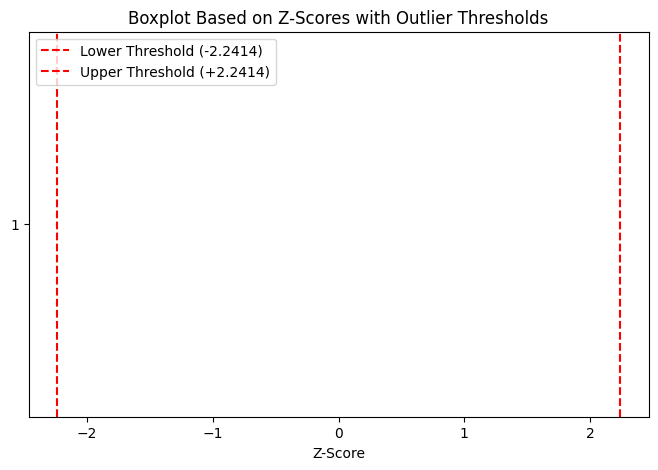

number of outliers found 0


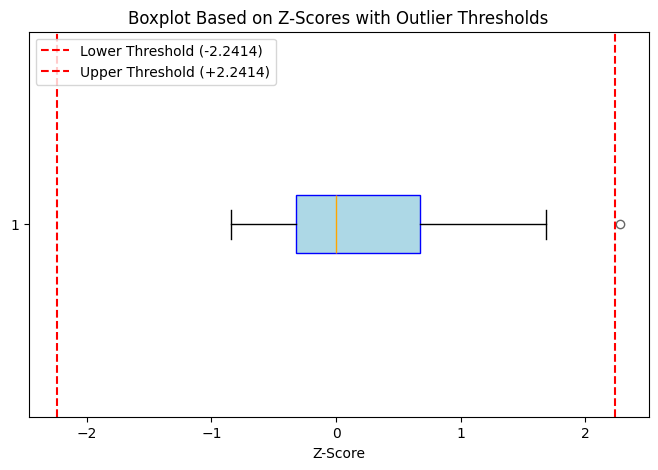

number of outliers found 1
Joint outlier indices: []


In [9]:
# SUDA outliers
results_suda = ST.rst_outlier_case2(suda, 'dis-score')
above_SUDAoutlier_indices = set(results_suda[4]) # Assuming the 4th element (index 3) is the list of outlier indices
print('number of outliers found',len(above_SUDAoutlier_indices))

#PIF outliers
results_pif = ST.rst_outlier_case2(pif, 'RIG')
above_PIFoutlier_indices = set(results_pif[4]) # Assuming the 4th element (index 3) is the list of outlier indices
print('number of outliers found',len(above_PIFoutlier_indices))

# Find the intersection of the two sets
joint_outlier_indices_set = above_SUDAoutlier_indices.intersection(above_PIFoutlier_indices)
joint_outlier_indices = list(joint_outlier_indices_set)
print("Joint outlier indices:", joint_outlier_indices)

### Chosen participant outlier

In [10]:
MID.loc[1]

,1
participant_id,sub-MSC02
gender,M
age,34
education_degree,Doctorate
education_years,28.0


## Correlation among privacy metrics.

In [11]:
# Spearman Rank Correlation
correlation_spearman, p_value = spearmanr(suda['score'], pif['RIG'])
print(f"Spearman Rank Correlation between suda & pif: {correlation_spearman:.2f},{p_value:.4f}")


# Kendall's Tau Correlation
tau, p_value = kendalltau(suda['score'], pif['RIG'])
print(f"Kendall's Tau between suda & pif: {tau:.2f}, p-value: {p_value:.4f}")

Spearman Rank Correlation between suda & pif: 0.69,0.0280
Kendall's Tau between suda & pif: 0.63, p-value: 0.0245


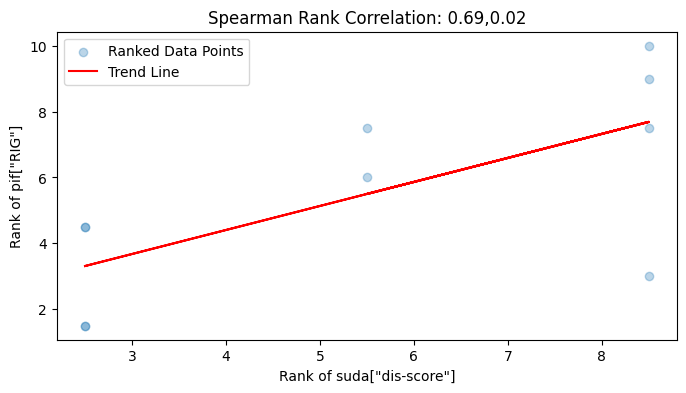

In [17]:
from scipy.stats import rankdata
import matplotlib.pyplot as plt

suda_ranked = rankdata(suda['score'])
pif_ranked = rankdata(pif['RIG'])
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(suda_ranked, pif_ranked, alpha=0.3, label='Ranked Data Points')
slope, intercept, _, _, _ = linregress(suda_ranked, pif_ranked)
ax.plot(suda_ranked, slope * suda_ranked + intercept, color='red', label='Trend Line')
ax.set_title(f'Spearman Rank Correlation: {correlation_spearman:.2f},{p_value:.2f}')
ax.set_xlabel('Rank of suda["dis-score"]')
ax.set_ylabel('Rank of pif["RIG"]')
ax.grid(False)
ax.legend()
plt.show()